In [27]:
# The code is run in google colab

In [2]:
!pip install tensorflow opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 821.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 18.9 MB/s eta 0:00:00


In [2]:
from google.colab import files
files.upload()  # choose kaggle.json from your computer


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ukegbuchidera","key":"1b92992f08c440825721b8864bde07fd"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip -q asl-alphabet.zip


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 98% 1.00G/1.03G [00:13<00:00, 56.2MB/s]
100% 1.03G/1.03G [00:13<00:00, 80.7MB/s]


Let's inspect the directory structure of the unzipped dataset to understand why `flow_from_directory` is only finding one class. We'll list the contents of the relevant directories.

In [5]:
!ls -R /content/asl_alphabet_train | head -n 30

/content/asl_alphabet_train:
asl_alphabet_train

/content/asl_alphabet_train/asl_alphabet_train:
A
B
C
D
del
E
F
G
H
I
J
K
L
M
N
nothing
O
P
Q
R
S
space
T
U
V
W


In [6]:
!ls -R /content/asl_alphabet_test | head -n 30

/content/asl_alphabet_test:
asl_alphabet_test

/content/asl_alphabet_test/asl_alphabet_test:
A_test.jpg
B_test.jpg
C_test.jpg
D_test.jpg
E_test.jpg
F_test.jpg
G_test.jpg
H_test.jpg
I_test.jpg
J_test.jpg
K_test.jpg
L_test.jpg
M_test.jpg
nothing_test.jpg
N_test.jpg
O_test.jpg
P_test.jpg
Q_test.jpg
R_test.jpg
space_test.jpg
S_test.jpg
T_test.jpg
U_test.jpg
V_test.jpg
W_test.jpg
X_test.jpg


In [7]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


In [8]:
# Define constants
IMG_SIZE = 160
BATCH_SIZE = 32

# Pre-process the data and create training and validation datasets
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

train_data = datagen.flow_from_directory(
    "/content/asl_alphabet_train/asl_alphabet_train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
)

val_data = datagen.flow_from_directory(
    "/content/asl_alphabet_train/asl_alphabet_train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
)

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_data = test_datagen.flow_from_directory(
    "/content/asl_alphabet_test/asl_alphabet_test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,  # important for correct predictions mapping
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 0 images belonging to 0 classes.


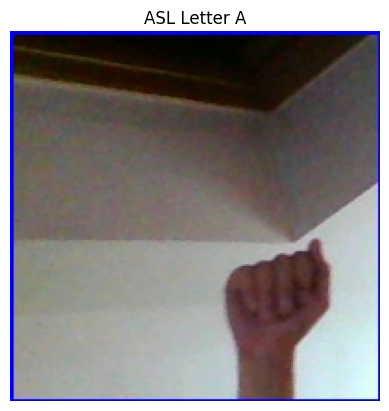

In [9]:
import matplotlib.pyplot as plt
import cv2
import os

# Path to a folder in your training data
# Example: first class 'A' in the training folder
train_folder = "/content/asl_alphabet_train/asl_alphabet_train/A"

# List all images in the folder
images = os.listdir(train_folder)

# Pick the first image
image_path = os.path.join(train_folder, images[9])

# Read the image using OpenCV
img = cv2.imread(image_path)

# OpenCV loads in BGR, convert to RGB for Matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display
plt.imshow(img)
plt.title("ASL Letter A")
plt.axis("off")
plt.show()


In [10]:
# Load MobileNetV2 base (pre-trained on ImageNet)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet"
)

# Freeze base layers
for layer in base_model.layers[-20:]:
    layer.trainable = True


# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
# Print model summary
model.summary()

# Implement early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data, validation_data=val_data, epochs=20, callbacks=[early_stop]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 2,559,261 (9.76 MB)

 Non-trainable params: 34,112 (133.25 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 661s 279ms/step - accuracy: 0.8693 - loss: 0.5138 - val_accuracy: 0.9253 - val_loss: 0.2937
Epoch 2/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 590s 271ms/step - accuracy: 0.9948 - loss: 0.0189 - val_accuracy: 0.9361 - val_loss: 0.2837
Epoch 3/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 585s 269ms/step - accuracy: 0.9956 - loss: 0.0156 - val_accuracy: 0.9611 - val_loss: 0.1541
Epoch 4/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 584s 269ms/step - accuracy: 0.9962 - loss: 0.0148 - val_accuracy: 0.9566 - val_loss: 0.2128
Epoch 5/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 629s 289ms/step - accuracy: 0.9965 - loss: 0.0131 - val_accuracy: 0.9461 - val_loss: 0.2509
Epoch 6/20
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 586s 270ms/step - accuracy: 0.9973 - loss: 0.0090 - val_accuracy: 0.9578 - val_loss: 0.1848


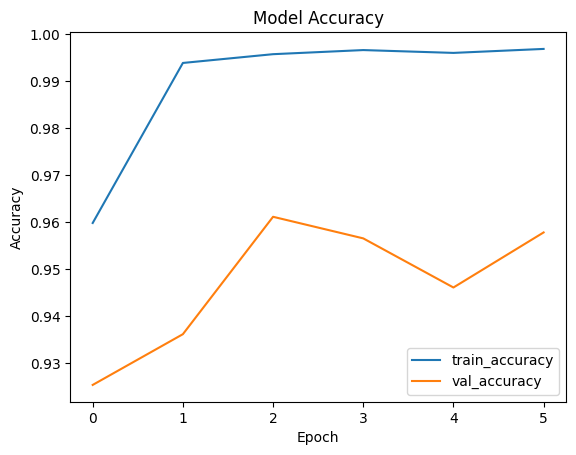

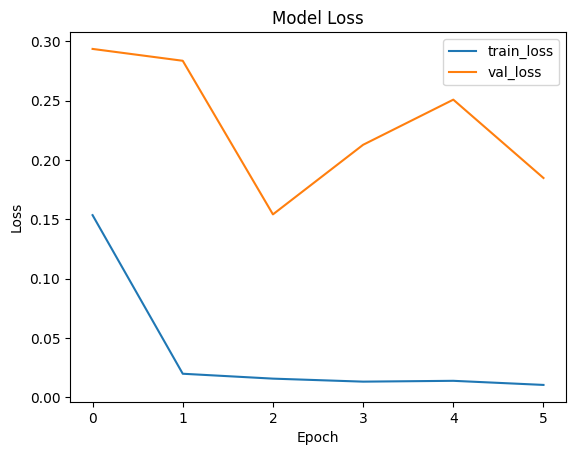

In [12]:
# Visualize training history
# Plot accuracy
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
# Save the trained model
model.save("asl_mobilenet_model.keras")


In [19]:
from google.colab import files
files.download('asl_mobilenet_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# Evaluate on the validation set
loss, accuracy = model.evaluate(val_data)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


544/544 ━━━━━━━━━━━━━━━━━━━━ 106s 194ms/step - accuracy: 0.9590 - loss: 0.1598
Validation Loss: 0.1516
Validation Accuracy: 96.10%


The test dataset is currently structured with all images directly in a single folder. For `ImageDataGenerator.flow_from_directory` to correctly infer classes, images for each class need to be in separate subdirectories. We will create these subdirectories and move the test images into them based on their filenames (e.g., 'A_test.jpg' goes into a folder named 'A').

In [20]:
import os
import shutil

test_dir = "/content/asl_alphabet_test/asl_alphabet_test"

# Get a list of all image files in the test directory
image_files = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Create subdirectories for each class and move images
for image_file in image_files:
    # Extract class label from filename (e.g., 'A' from 'A_test.jpg')
    # Special handling for 'del', 'nothing', 'space' as they are not single letters
    if image_file.startswith('nothing'):
        class_name = 'nothing'
    elif image_file.startswith('space'):
        class_name = 'space'
    elif image_file.startswith('del'):
        class_name = 'del'
    else:
        class_name = image_file[0] # Assuming first character is the class

    class_dir = os.path.join(test_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    shutil.move(os.path.join(test_dir, image_file), os.path.join(class_dir, image_file))

print("Test dataset restructured into class subdirectories.")



Test dataset restructured into class subdirectories.


In [21]:
class_labels = list(train_data.class_indices.keys())


# Function to predict ASL sign from an image
def predict_asl_image(image_path, model, class_labels, IMG_SIZE=64):
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Image not found at", image_path)
        return None

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred_probs = model.predict(img)
    class_index = np.argmax(pred_probs)
    confidence = pred_probs[0][class_index] * 100

    predicted_letter = class_labels[class_index]
    print(f"Predicted sign: {predicted_letter} ({confidence:.2f}% confidence)")

    return predicted_letter


In [23]:
predict_asl_image("/content/asl_alphabet_test/asl_alphabet_test/A/A_test.jpg", model, class_labels, IMG_SIZE=IMG_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted sign: A (100.00% confidence)


'A'

In [24]:
predict_asl_image("/content/asl_alphabet_test/asl_alphabet_test/M/M_test.jpg", model, class_labels, IMG_SIZE=IMG_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted sign: M (99.88% confidence)


'M'

In [25]:
predict_asl_image("/content/asl_alphabet_test/asl_alphabet_test/R/R_test.jpg", model, class_labels, IMG_SIZE=IMG_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted sign: R (100.00% confidence)


'R'